# Word2Vec with Skip-Gram Architecture

## Imports

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dot, Flatten
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.optimizers import Adam
import re
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import kagglehub

# Enable mixed precision
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

2024-11-10 04:44:58.799957: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 04:44:58.818011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731210298.837922     329 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731210298.844128     329 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 04:44:58.865378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Word2Vec Class

In [25]:
class Word2VecImplementation:
    """
    Implementation for the Word2Vec Class
    """
    def __init__(self, embedding_dim=100, window_size=5, min_count=5, negative_samples=15):
        self.embedding_dim = embedding_dim # Size of the embedding dimension
        self.window_size = window_size #Size of the window for skipgram
        self.min_count = min_count #Minimum count for a word to be considered
        self.negative_samples = negative_samples #No of samples to be considered for negetive sampling  
        self.tokenizer = None #Tokeinzer
        self.model = None #Stores the Model
        self.vocab_size = None #Size of the recorded vocabulary
        self.word_to_idx = None #List of mappings from Words to ids
        self.idx_to_word = None #List of mappings from ids to words

    def load_and_preprocess_corpus(self, filepath, max_sentences=30000):
        """
        Function to read the data and load  it.
        """
        print("Loading corpus...")
        #opening the file and reading the inputs line by line
        with open(filepath, 'r', encoding='utf-8') as file:
            texts = [next(file).strip() for _ in range(max_sentences)]
        
        print(f"Loaded {len(texts)} sentences")
        #Returning a list of preprocessed texts
        return self.preprocess_text(texts)

    def preprocess_text(self, texts):
        """
        Preprocess the input texts.
    
        Parameters:
        texts (list): List of strings, each string is a sentence
    
        Returns:
        list: List of lists, where each inner list contains tokens of a sentence
    
        Requirements:
        1. Convert text to lowercase
        2. Remove special characters and punctuation
        3. Filter words based on minimum frequency (self.min_count)
        4. Create word-to-index and index-to-word mappings
        5. Update self.vocab_size
        """
        processed_texts = [] #List to store the list of all processed texts
        word_counts = Counter() #List to stire the number of unique words and their frequency
    
        print(f"Initial number of texts: {len(texts)}")
    
        for text in texts:
            # Convert to lowercase and remove special characters
            text = text.lower() #Convert the text to lower case
            text = re.sub(r'[^a-zA-Z\s]', '', text) #Remove special characters
            tokens = text.split() #Splitting the texts into words
            processed_texts.append(tokens) #Appending the processed texts with tokens
            word_counts.update(tokens) #Updating the words with individual words
    
        # Counting only the words above minimum frequency
        valid_words = {word for word, count in word_counts.items() if count >= self.min_count}
        print(f"Vocabulary size after frequency filtering: {len(valid_words)}")
    
        # Creating the mapping rom words to indexes and vice versa
        self.word_to_idx = {word: idx + 1 for idx, word in enumerate(valid_words)}
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
    
        # Adding the padding token as the first token
        self.word_to_idx['<PAD>'] = 0
        self.idx_to_word[0] = '<PAD>'
    
        # Updating the vocabulary size
        self.vocab_size = len(self.word_to_idx)
        print(f"Final vocabulary size: {self.vocab_size}")
    
        # Filtering the tokens and converting them
        filtered_texts = [] #list of filtered tokens
        for tokens in processed_texts:
            filtered_tokens = [token for token in tokens if token in valid_words]
            if filtered_tokens:  # Only add non-empty sequences
                filtered_texts.append(filtered_tokens)
    
        print(f"Number of filtered texts: {len(filtered_texts)}")
        if filtered_texts:
            print(f"Average tokens per text: {sum(len(t) for t in filtered_texts)/len(filtered_texts):.2f}")

        #returning the list of all filtered texts
        return filtered_texts

    def generate_training_pairs(self, tokenized_texts):
        """
        Generate training pairs using skipgrams.
    
        Parameters:
        tokenized_texts (list): List of tokenized sentences
    
        Returns:
        tuple: (pairs, labels)
            - pairs: numpy array of shape (N, 2) containing word index pairs
            - labels: numpy array of shape (N,) containing binary labels
        
        Requirements:
        1. Use window_size from self.window_size
        2. Generate negative samples using self.negative_samples
        3. Convert words to their indices using self.word_to_idx
        """
        if not tokenized_texts:
            print("Error: No tokenized texts provided")
            return np.array([]), np.array([])
        
        #Creating the list of context words, target words and labels
        target_words = []
        context_words = []
        labels = []
    
        print(f"Generating pairs from {len(tokenized_texts)} texts")

        #Building the skipgram architecture
        for sentence in tokenized_texts:
            # Converting words to indices
            word_indices = [self.word_to_idx[word] for word in sentence if word in self.word_to_idx]
        
            if not word_indices:
                continue
            
            # Generating skipgrams for each sentence
            for i, target in enumerate(word_indices):
                # Define context window
                start = max(0, i - self.window_size)
                end = min(len(word_indices), i + self.window_size + 1)
            
                # Getting only positive samples
                context_words_indices = word_indices[start:i] + word_indices[i+1:end]
                for context in context_words_indices:
                    target_words.append(target)
                    context_words.append(context)
                    labels.append(1)
                
                    # Generating the negative samples
                    for _ in range(self.negative_samples):
                        negative_idx = np.random.randint(1, self.vocab_size)
                        while negative_idx in context_words_indices:
                            negative_idx = np.random.randint(1, self.vocab_size)
                        target_words.append(target)
                        context_words.append(negative_idx)
                        labels.append(0)
    
        print(f"Generated {len(target_words)} training pairs")
        #The case when there are no target words
        if not target_words:
            print("Error: No training pairs generated")
            return np.array([]), np.array([])
        
        return np.array([target_words, context_words]).T, np.array(labels)

    def create_model(self):
        """
        Create the Skip-gram model architecture.
    
        Requirements:
        1. Use embedding dimension from self.embedding_dim
        2. Create target and context embeddings
        3. Implement negative sampling
        4. Use appropriate loss function and optimizer
        5. Store model in self.model
        """
        # Configure GPU memory growth
        physical_devices = tf.config.list_physical_devices('GPU')
        try:
            if physical_devices:
                for device in physical_devices:
                    tf.config.experimental.set_memory_growth(device, True)
        except:
            print("Memory growth setting failed. Continuing with default settings.")

        # Set computation precision
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
    
        with tf.device('/GPU:0'):
            # Input layers for target and context words
            target_input = Input(shape=(1,), dtype='int32')
            context_input = Input(shape=(1,), dtype='int32')
        
            # Embedding layers with explicit dtype
            target_embedding = Embedding(
                self.vocab_size,
                self.embedding_dim,
                embeddings_initializer='uniform',
                dtype='float32',
                name='target_embedding'
            )(target_input)

            #Creating the context embedding
            context_embedding = Embedding(
                self.vocab_size,
                self.embedding_dim,
                embeddings_initializer='uniform',
                dtype='float32',
                name='context_embedding'
            )(context_input)
        
            # Flattening the embeddings
            target_flat = Flatten()(target_embedding)
            context_flat = Flatten()(context_embedding)
        
            # Computing dot product
            dot_product = Dot(axes=1)([target_flat, context_flat])
        
            # Adding sigmoid activation
            output = Dense(1, activation='sigmoid')(dot_product)
        
            # Creating the model
            self.model = Model(inputs=[target_input, context_input], outputs=output)
        
            # Compiling the model
            optimizer = Adam(learning_rate=0.01)
            self.model.compile(
                loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy']
            )

    def train(self, pairs, labels, epochs=10, batch_size=2048):
        """
        Train the Word2Vec model.
        
        Args:
            pairs (numpy.array): Training pairs
            labels (numpy.array): Training labels
            epochs (int): Number of training epochs
            batch_size (int): Batch size
            
        Returns:
            history: Training history
            
        Required steps:
        1. Implement training loop
        2. Add validation split
        3. Include early stopping
        4. Track and return training history
        """
        if len(pairs) == 0 or len(labels) == 0:
            print("Error: No training data available")
            return None
    
        print(f"Training data shape - Pairs: {pairs.shape}, Labels: {labels.shape}")
    
        # Converting data to appropriate types
        pairs = pairs.astype(np.int32)
        labels = labels.astype(np.float32)
    
        # Splitting data for validation
        split_idx = int(len(pairs) * 0.9)
    
        # Splitting the data into training and validation pairs
        train_pairs = pairs[:split_idx]
        train_labels = labels[:split_idx]
        val_pairs = pairs[split_idx:]
        val_labels = labels[split_idx:]
    
        print(f"Training set size: {len(train_pairs)}")
        print(f"Validation set size: {len(val_pairs)}")
    
        # Preparing the inputs
        train_target = train_pairs[:, 0].astype(np.int32)
        train_context = train_pairs[:, 1].astype(np.int32)
        val_target = val_pairs[:, 0].astype(np.int32)
        val_context = val_pairs[:, 1].astype(np.int32)
    
        try:
            # Creating dataset using appropriate data structures
            train_dataset = tf.data.Dataset.from_tensor_slices((
                {
                    'input_1': train_target,
                    'input_2': train_context
                },
                train_labels
            )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

            val_dataset = tf.data.Dataset.from_tensor_slices((
                {
                    'input_1': val_target,
                    'input_2': val_context
                },
                val_labels
            )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

            # Training with validation
            history = self.model.fit(
                train_dataset,
                validation_data=val_dataset,
                epochs=epochs,
                callbacks=[
                    tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=3,
                        restore_best_weights=True
                    ),
                    tf.keras.callbacks.ReduceLROnPlateau(
                        monitor='val_loss',
                        factor=0.5,
                        patience=2,
                        min_lr=0.00001
                    )
                ]
            )
        
            return history

        #Exception purely created to handlw exceptions from GPU
        except Exception as e:
            print(f"Training failed with error: {str(e)}")
            print("GPU Memory info:")
            print(tf.config.experimental.get_memory_info('GPU:0'))
            return None

    def find_similar_words(self, word, top_k=5):
        """
        Find most similar words using cosine similarity.
    
        Parameters:
        word (str): Query word
        top_k (int): Number of similar words to return
    
        Returns:
        list: List of tuples (similar_word, similarity_score)
    
        Requirements:
        1. Use cosine similarity
        d2. Exclude the query word from results
        3. Return top_k most similar words
        """
        if word not in self.word_to_idx:
            return []
    
        # Get target word embedding weights
        target_embeddings = self.model.get_layer('target_embedding').get_weights()[0]
    
        # Get the embedding for the input word
        word_idx = self.word_to_idx[word]
        word_embedding = target_embeddings[word_idx]
    
        # Calculate cosine similarities
        similarities = []
        for idx in range(self.vocab_size):
            if idx != word_idx:
                other_embedding = target_embeddings[idx]
                similarity = np.dot(word_embedding, other_embedding) / (
                    np.linalg.norm(word_embedding) * np.linalg.norm(other_embedding)
                )
                similarities.append((self.idx_to_word[idx], similarity))
    
        # Sort all the similar words by cosine value and return the top_k elements
        return sorted(similarities, key=lambda x: x[1], reverse=True)[:top_k]

    def visualize_test_words(self, test_words, num_similar=5):
        """
        Visualize test words and their similar words using t-SNE.
    
        Parameters:
        test_words (list): List of words to visualize
        num_similar (int): Number of similar words to show for each test word
    
        Requirements:
        1. Use t-SNE for dimensionality reduction
        2. Create clear visual distinction between test words and similar words
        3. Show relationships between words
        4. Include appropriate legend and labels
        """
        # Creating the embeddings
        embeddings = self.model.get_layer('target_embedding').get_weights()[0]
    
        # Collect words and their embeddings for visualization
        words_to_plot = []
        embeddings_to_plot = []
        colors = []

        #Taking each test words and plotting the nearby words
        for test_word in test_words:
            if test_word not in self.word_to_idx:
                continue
            
            # Adding test word
            words_to_plot.append(test_word)
            embeddings_to_plot.append(embeddings[self.word_to_idx[test_word]])
            colors.append('red')  # Test words in red
        
            # Adding similar words
            similar_words = self.find_similar_words(test_word, top_k=num_similar)
            for similar_word, _ in similar_words:
                words_to_plot.append(similar_word)
                embeddings_to_plot.append(embeddings[self.word_to_idx[similar_word]])
                colors.append('blue')  # Similar words in blue
    
        # Check if we have enough words to visualize
        n_samples = len(embeddings_to_plot)
        if n_samples < 4:
            print("Not enough samples to create visualization. Need at least 4 words.")
            return
        
        # Calculate appropriate perplexity
        # Rule of thumb: perplexity should be between 5 and 50, and less than n_samples/3
        perplexity = min(30, max(5, n_samples//3))
    
        # Apply t-SNE with adjusted parameters
        tsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            random_state=42,
            n_iter=1000,
            learning_rate='auto',
            init='pca'
        )

        # Implementing try except when ther
        try:
            embeddings_2d = tsne.fit_transform(np.array(embeddings_to_plot))
        
            # Create plot
            plt.figure(figsize=(12, 8))
        
            # Plot points with different colors for test words and similar words
            for i, (word, coord, color) in enumerate(zip(words_to_plot, embeddings_2d, colors)):
                x, y = coord
                plt.scatter(x, y, c=color, alpha=0.6)
                plt.annotate(word, (x, y), alpha=0.8, 
                            xytext=(5, 5), textcoords='offset points')
        
            # Add legend and title
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor='red', label='Test Words', markersize=10),
                             plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor='blue', label='Similar Words', markersize=10)]
            plt.legend(handles=legend_elements)
        
            plt.title('Word Embeddings Visualization')
            plt.grid(True, alpha=0.3)
            plt.show()
        
        except Exception as e:
            print(f"Visualization failed with error: {str(e)}")
            print(f"Number of samples: {n_samples}")
            print(f"Attempted perplexity: {perplexity}")
        

Dataset downloaded to: /home/user/.cache/kagglehub/datasets/luisgasparcordeiro/14-million-word-corpus-txt/versions/1/corpus.txt
Loading corpus...
Loaded 10000 sentences
Initial number of texts: 10000
Vocabulary size after frequency filtering: 16835
Final vocabulary size: 16836
Number of filtered texts: 6911
Average tokens per text: 60.60
Generating pairs from 6911 texts
Generated 45910740 training pairs
Generated 45910740 training pairs
Training data shape - Pairs: (45910740, 2), Labels: (45910740,)
Training set size: 41319666
Validation set size: 4591074
Epoch 1/5
Training failed with error: Missing data for input "input_layer_20". You passed a data dictionary with keys ['input_1', 'input_2']. Expected the following keys: ['input_layer_20', 'input_layer_21']
GPU Memory info:
{'current': 292654080, 'peak': 308605952}

Word Similarities:

Similar words to 'man':
  youll: 0.5880
  experimenters: 0.5463
  arrest: 0.5047
  handed: 0.4760
  prophecy: 0.4693

Similar words to 'woman':
  valv

/home/user/miniconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


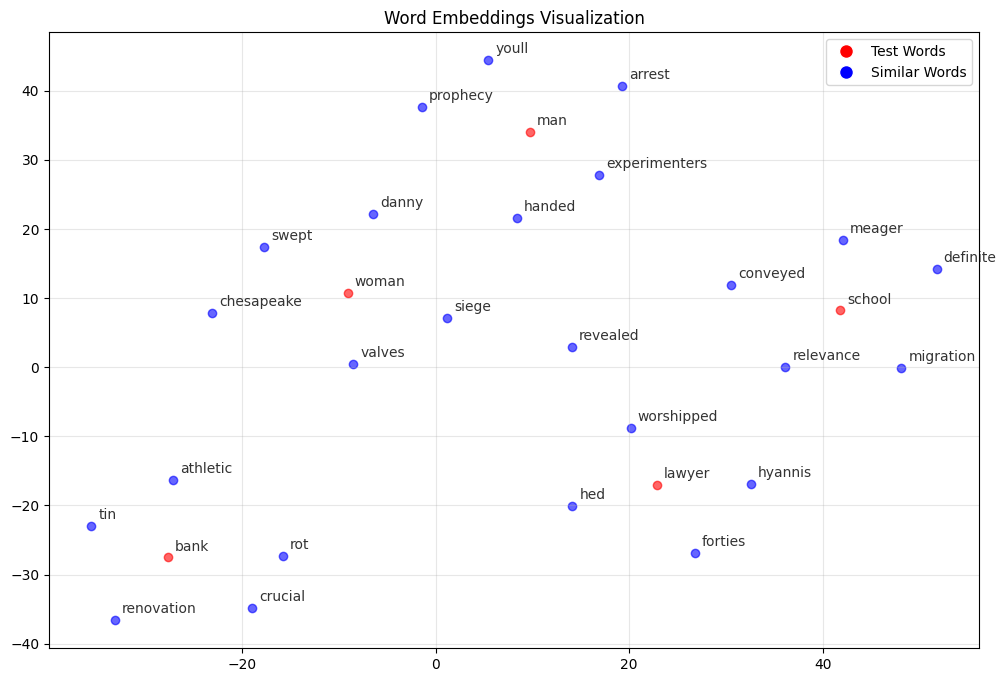

In [26]:
print("Downloading dataset from Kaggle...")
dataset_path = kagglehub.dataset_download(
    'luisgasparcordeiro/14-million-word-corpus-txt'
)

# The dataset path will be provided by kagglehub
corpus_file = os.path.join(dataset_path, 'corpus.txt')

print(f"Dataset downloaded to: {corpus_file}")

# Initialize model
w2v = Word2VecImplementation(
    embedding_dim=50,
    window_size=10,
    min_count=2,
    negative_samples=5
)

# Load and preprocess corpus
tokenized_texts = w2v.load_and_preprocess_corpus(
    corpus_file,
    max_sentences=10000  # Adjust based on your resources
)

# Continue with training...
pairs, labels = w2v.generate_training_pairs(tokenized_texts)
print(f"Generated {len(pairs)} training pairs")

w2v.create_model()
history = w2v.train(pairs, labels, epochs=5, batch_size=1024) #adjust as you like

# Test words grouped by semantic relationships

test_words = [
    'man', 'woman', 'lawyer', 'school',
    'bank'
]

# First print similarities
print("\nWord Similarities:")
for word in test_words:
    if word in w2v.word_to_idx:
        similar_words = w2v.find_similar_words(word, top_k=5)
        print(f"\nSimilar words to '{word}':")
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity:.4f}")
    else:
        print(f"\nWord '{word}' not in vocabulary")

# Then visualize
print("\nCreating visualization...")
w2v.visualize_test_words(test_words, num_similar=5)